In [18]:
import pandas as pd
import numpy as np
import re
import scanpy as sc
import anndata
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import scanpy.external as sce
import scyan
from concurrent.futures import ProcessPoolExecutor
import copy
import os
import gc
import matplotlib.pyplot as plt

sc.settings.n_jobs = 60

In [15]:
def leiden_new(
    adata,
    resolution: float = 1,
    key_added: str = "leiden",
    n_neighbors: int = 15,
) -> None:
    """Leiden clustering

    Args:
        adata: AnnData object.
        resolution: Resolution of the clustering.
        key_added: Name of the key of adata.obs where clusters will be saved.
        n_neighbors: Number of neighbors.
    """
    try:
        import leidenalg
    except:
        raise ImportError(
            """To run leiden, you need to have 'leidenalg' installed. You can install the population discovery extra with "pip install 'scyan[discovery]'", or directly install leidenalg with "conda install -c conda-forge leidenalg"."""
        )

    import igraph as ig
    from sklearn.neighbors import kneighbors_graph

    if not "knn_graph" in adata.obsp:
        adata.obsp["knn_graph"] = kneighbors_graph(
            adata.obsm['X_pca_harmony'][:,0:10], n_neighbors=n_neighbors, metric="euclidean", include_self=False
        )

    # TODO (improvement): add weights according to euclidean distance
    graph = ig.Graph.Weighted_Adjacency(adata.obsp["knn_graph"], mode="DIRECTED")

    partition = leidenalg.find_partition(
        graph,
        leidenalg.RBConfigurationVertexPartition,
        resolution_parameter=resolution,
    )
    adata.obs[key_added] = pd.Categorical([str(x) for x in partition.membership])

def run_leiden(adata, resolution, key_added):
    # Make a copy of adata for thread safety
    adata_copy = copy.deepcopy(adata)
    leiden_new(adata_copy, resolution=resolution, key_added=key_added)
    return adata_copy.obs
 
def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        # Make deep copies of adata for each task to ensure thread safety
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        
        results = [future.result() for future in futures]
 
    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]
 
    return adata
def read_one(file_path):
    adata = scyan.read_csv(file_path,
                        marker_regex='^cd|^hla|tcr|ig|^ccr|klrg|^cx', 
                        exclude_markers=None)
    adata.obs["batch"] = re.findall( 'B\\d\\d\\d', file_path)[0]
    adata.obs["panel"] = re.findall( 'PB1|PT1|PM1|PS1', file_path)[0]

    return adata

In [2]:
adata=sc.read_h5ad("adata_cm_cd4_leiden_var15_umap.h5ad")

In [9]:
adata_PD1_CDCR5=adata[adata.obs['leiden_res_1.5']=='11']

In [11]:
adata_PD1_CDCR5=adata_PD1_CDCR5.raw.to_adata()

In [12]:
scyan.preprocess.scale(adata_PD1_CDCR5)
sc.pp.pca(adata_PD1_CDCR5, svd_solver="arpack")

[INFO] (scyan.preprocess) Data will be centered and standardised. This is advised only when using spectral/flow data (if this is not your case, consider running 'asinh_transform' instead of 'auto_logicle_transform').


In [13]:
%%time

sce.pp.harmony_integrate(adata_PD1_CDCR5, 'batch',max_iter_harmony = 20)

2024-08-29 16:42:41,460 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-29 16:43:14,478 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-29 16:43:16,308 - harmonypy - INFO - Iteration 1 of 20
2024-08-29 16:46:39,049 - harmonypy - INFO - Iteration 2 of 20
2024-08-29 16:50:04,347 - harmonypy - INFO - Iteration 3 of 20
2024-08-29 16:53:27,398 - harmonypy - INFO - Iteration 4 of 20
2024-08-29 16:56:51,419 - harmonypy - INFO - Iteration 5 of 20
2024-08-29 17:00:23,567 - harmonypy - INFO - Iteration 6 of 20
2024-08-29 17:03:54,064 - harmonypy - INFO - Iteration 7 of 20
2024-08-29 17:07:15,975 - harmonypy - INFO - Iteration 8 of 20
2024-08-29 17:09:39,686 - harmonypy - INFO - Iteration 9 of 20
2024-08-29 17:11:35,562 - harmonypy - INFO - Iteration 10 of 20
2024-08-29 17:13:11,834 - harmonypy - INFO - Iteration 11 of 20
2024-08-29 17:14:31,258 - harmonypy - INFO - Iteration 12 of 20
2024-08-29 17:15:49,233 - harmonypy - INFO - Converged after

CPU times: user 5h 3min 27s, sys: 6h 40min 3s, total: 11h 43min 30s
Wall time: 33min 8s


In [14]:
sc.pp.neighbors(adata_PD1_CDCR5,use_rep='X_pca_harmony')
sc.tl.umap(adata_PD1_CDCR5)


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [16]:
%%time
tasks = [(0.5, "leiden_res_0.5_subset"),
         (1.5, "leiden_res_1.5_subset"),
         (2, "leiden_res_2_subset"),
         (1, "leiden_res_1_subset")]
adata_PD1_CDCR5 = run_leiden_parallel(adata_PD1_CDCR5, tasks)

CPU times: user 2.69 s, sys: 4.07 s, total: 6.76 s
Wall time: 11min 24s


/opt/conda/lib/python3.10/site-packages/scyan/plot/_scanpy_plot/umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scyan/plot/_scanpy_plot/umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scyan/plot/_scanpy_plot/umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_actio

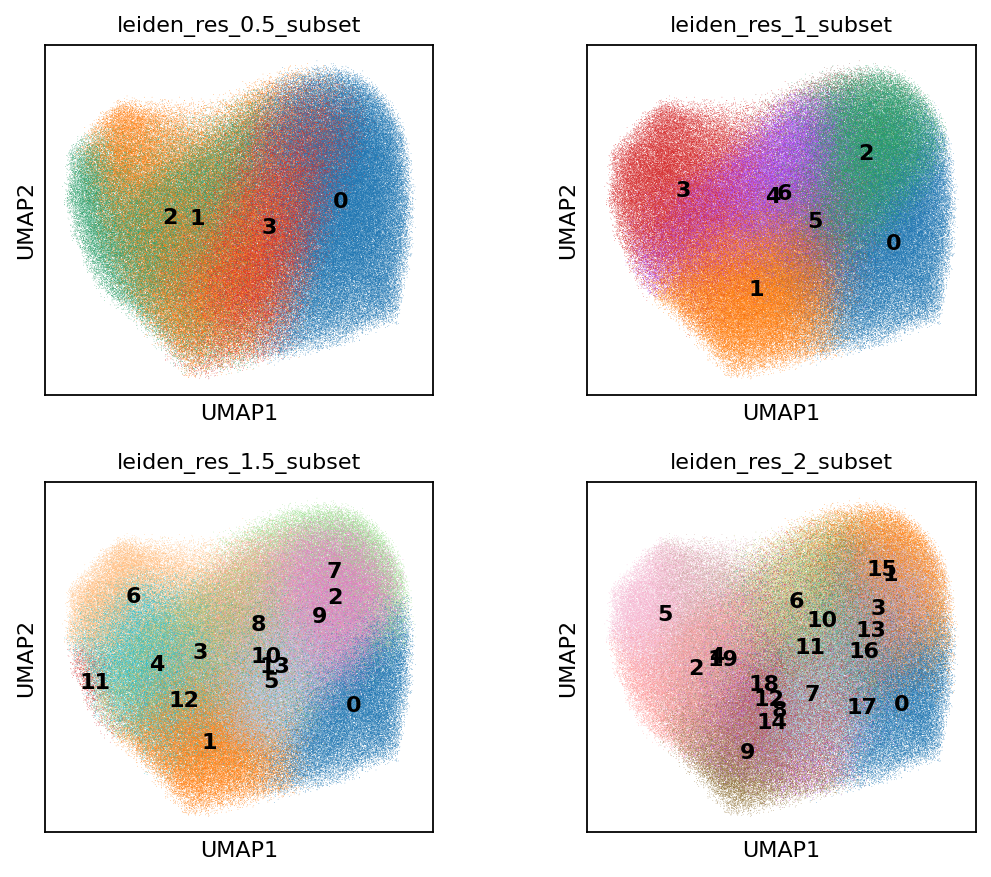

In [21]:
plt.rcParams['figure.figsize'] = [3, 3]

p1=scyan.plot.umap(adata_PD1_CDCR5, color=['leiden_res_0.5_subset','leiden_res_1_subset',
                                           'leiden_res_1.5_subset','leiden_res_2_subset'], 
                   show=True, legend_loc='on data',
                   ncols=2 ,return_fig=True)

In [22]:
adata_PD1_CDCR5

AnnData object with n_obs × n_vars = 378917 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'leiden_res_0.25', 'leiden_res_0.5', 'leiden_res_1.5', 'leiden_res_2', 'leiden_res_0.75', 'leiden_res_0.5_subset', 'leiden_res_1.5_subset', 'leiden_res_2_subset', 'leiden_res_1_subset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'neighbors', 'pca', 'scyan_scaling_means', 'scyan_scaling_stds', 'umap', 'leiden_res_0.5_subset_colors', 'leiden_res_1_subset_colors', 'leiden_res_1.5_subset_colors', 'leiden_res_2_subset_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

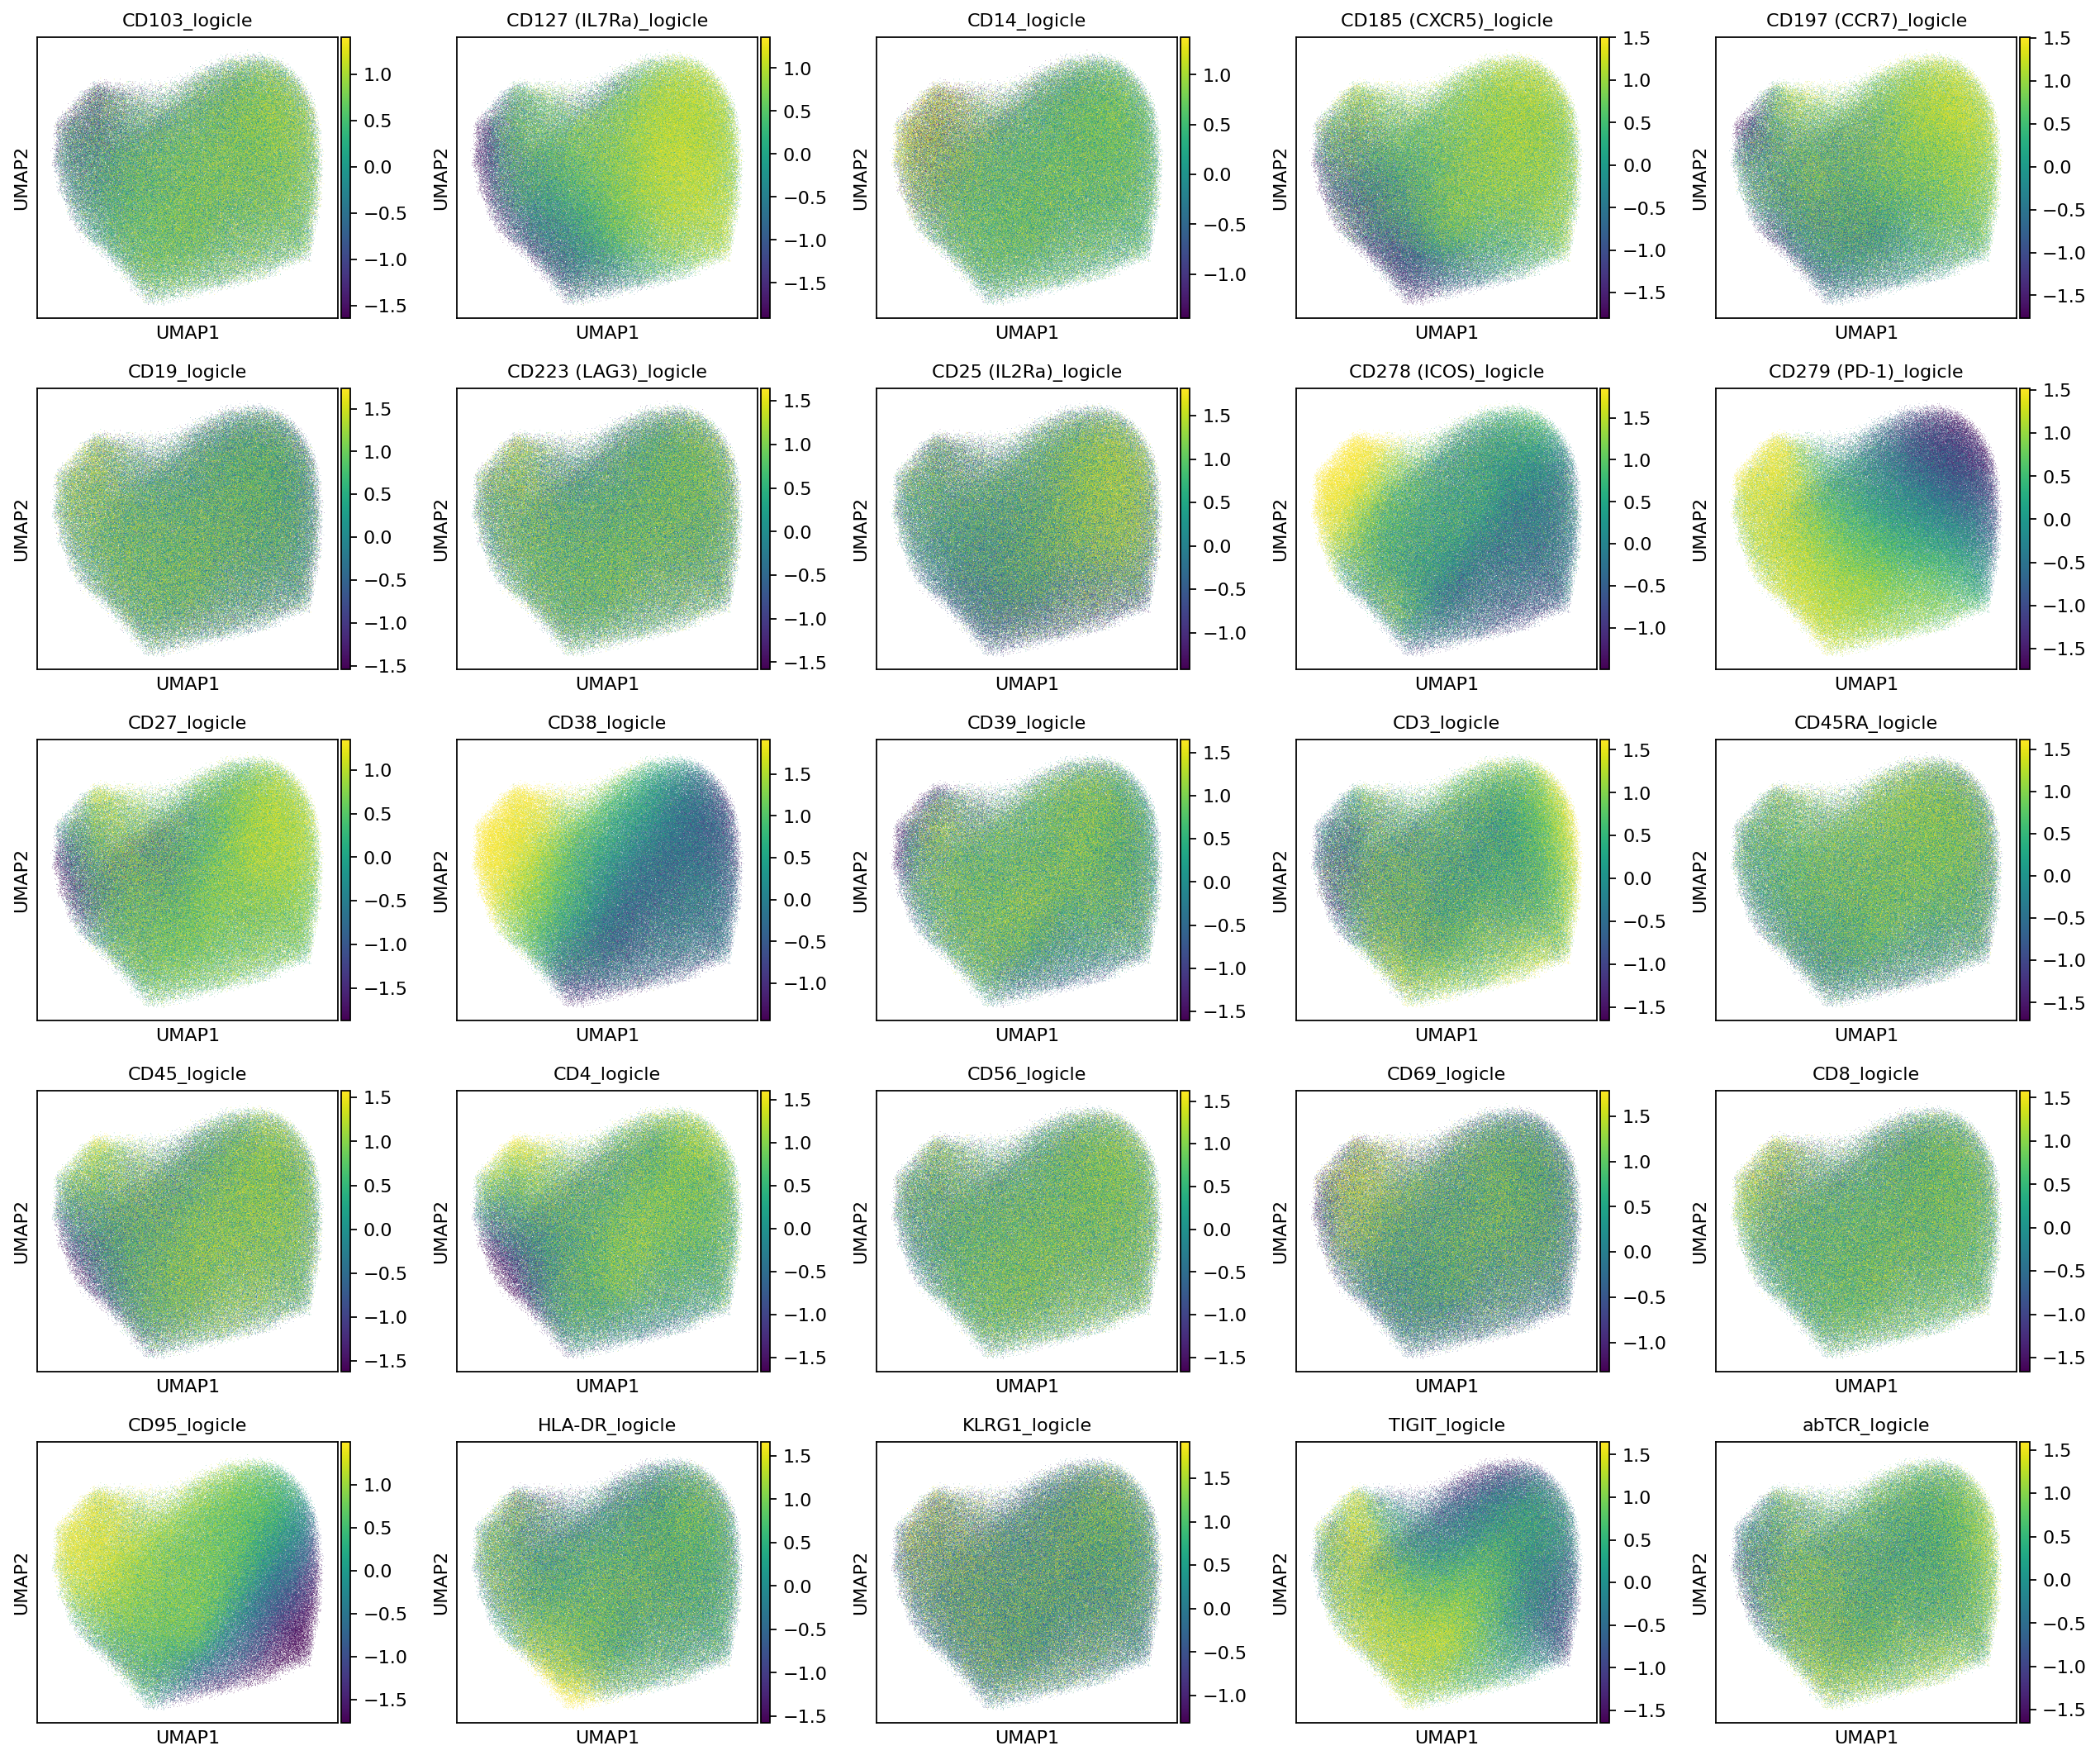

In [20]:
plt.rcParams['figure.figsize'] = [3, 3]

scyan.plot.umap(adata_PD1_CDCR5
                , color=adata_PD1_CDCR5.var_names.sort_values(),ncols=5, show=True)


In [25]:
adata_PD1_CDCR5.write_h5ad('adata_pdcd1_cxcr5_tfh.h5ad')